# Setup Code

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# imports
import torch
import torch.nn.functional as F
import numpy as np
import sys
import os
from matplotlib import pyplot as plt

In [3]:
# select devices
if torch.cuda.is_available():
    print("Good to go!")
    DEVICE = torch.device("cuda")
else:
    print("Bad to go!")
    DEVICE = torch.device("cpu")

Good to go!


Load config from config files.

In [4]:
# load config
sys.path.append(os.getcwd())
# choose between ship, lego
import configs.ship, configs.lego
sample_t: tuple = (2,6)
# change config file here
config = configs.lego

Load the dataset and show the first one.

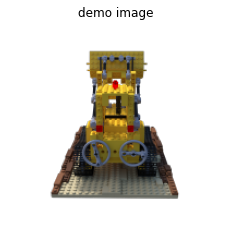

and its pose: 
[[-9.99902189e-01  4.19224519e-03 -1.33457193e-02 -5.37983216e-02]
 [-1.39886811e-02 -2.99659073e-01  9.53943670e-01  3.84547043e+00]
 [-4.65661287e-10  9.54037189e-01  2.99688309e-01  1.20808232e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [5]:
from nerf.data import load_blender
imgs, poses, int_mat = load_blender(config.datadir, device=DEVICE, scale_factor=2)
img_n, img_h, img_w = imgs.shape[:3]
# visualize
plt.imshow(np.array(imgs[0].to(device="cpu")))
plt.axis("off")
plt.title("demo image")
plt.show()
print("and its pose: ")
print(np.array(poses[0].to(device="cpu")))

Compute rays

In [6]:
from nerf.graphics import compute_rays

rays_o, rays_d = compute_rays((img_h, img_w), int_mat, poses[0])
print("origin: ", rays_o[0,0])
print("normalized origin: ", F.normalize(rays_o[0,0], dim=0))
print("center of ray: ", rays_d[img_h//2,img_w//2])

origin:  tensor([-0.0538,  3.8455,  1.2081], device='cuda:0', dtype=torch.float64)
normalized origin:  tensor([-0.0133,  0.9539,  0.2997], device='cuda:0', dtype=torch.float64)
center of ray:  tensor([ 4.6566e-10, -9.5404e-01, -2.9969e-01], device='cuda:0',
       dtype=torch.float64)


In [7]:
from nerf.graphics import queries_from_rays
samples = None
samples, depths = queries_from_rays(rays_o, rays_d, sample_t, 8)
print(depths)

tensor([ 4.1402,  5.1448,  6.5321,  7.5754,  8.5770,  9.7709, 10.9688, 12.0565],
       device='cuda:0')


In [8]:
# test posencode

from nerf.nerf_helper import PosEncode

L = 2
x = torch.tensor([[1.1, 1.2, 1.3], [2.1, 2.2, 2.3]])
enc_x = PosEncode(x, L)

print(enc_x)


tensor([[0.5038, 0.8638, 0.8704, 0.4923, 0.5447, 0.8386, 0.9136, 0.4066, 0.5843,
         0.8115, 0.9484, 0.3172],
        [0.5233, 0.8521, 0.8919, 0.4523, 0.5455, 0.8381, 0.9144, 0.4049, 0.5673,
         0.8235, 0.9343, 0.3564]])


# Train

In [9]:
# One iteration of TinyNeRF (forward pass).


tensor([0., 0., 0.], device='cuda:0', grad_fn=<SelectBackward0>)
val pred_rgb torch.Size([200, 200, 3])
Iteration  0
Val loss:  tensor(0.0348, device='cuda:0', grad_fn=<MseLossBackward0>)


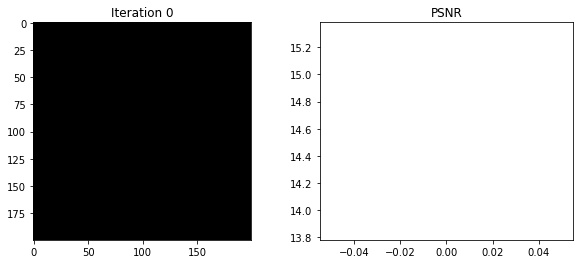

tensor([0., 0., 0.], device='cuda:0', grad_fn=<SelectBackward0>)
tensor([0., 0., 0.], device='cuda:0', grad_fn=<SelectBackward0>)
tensor([0., 0., 0.], device='cuda:0', grad_fn=<SelectBackward0>)
tensor([0., 0., 0.], device='cuda:0', grad_fn=<SelectBackward0>)
tensor([0., 0., 0.], device='cuda:0', grad_fn=<SelectBackward0>)
tensor([0., 0., 0.], device='cuda:0', grad_fn=<SelectBackward0>)


KeyboardInterrupt: 

In [16]:
from nerf.model import NeRF
from nerf.nerf_helper import nerf_iter_once

# parameters
L_pos = 10
L_dir = 4
depth_samples_per_ray = 32

chunksize = 8192
lr = 5e-3
betas=(0.9, 0.999)
num_it = 100
display_every = 10

# load validation data
imgs_val, poses_val, int_mat_val = load_blender(config.datadir, data_type="val",scale_factor=2, device=DEVICE)
num_val = imgs_val.shape[0]

# models
model = NeRF(ch_in_pos=6*L_pos, ch_in_dir=6*L_dir, fc_width=64)
model.to(DEVICE)

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=lr,
    betas=betas,
)

# train
psnrs = []
its = []
for i in range(num_it):
    gt_img_idx = np.random.randint(img_n)
    gt_img = imgs[gt_img_idx].to(DEVICE)
    gt_c2w = poses[gt_img_idx]

    pred_rgb,_ = nerf_iter_once(
                model,
                (img_h, img_w),
                int_mat,
                gt_c2w,
                sample_t,
                num_samples=4
                )

    print(pred_rgb[0,0])
    loss = torch.nn.functional.mse_loss(pred_rgb, gt_img[...,:3])
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    if i % display_every == 0:
        val_idx = 1
        val_img = imgs[val_idx].to(DEVICE)
        val_c2w = poses[val_idx]
        # val_idx = np.random.randint(num_val)
        # val_img = imgs_val[val_idx].to(DEVICE)
        # val_c2w = poses_val[val_idx]

        pred_rgb,_ = nerf_iter_once(
                model,
                (img_h, img_w),
                int_mat,
                val_c2w,
                sample_t,
                num_samples=4
                )

        print("val pred_rgb", pred_rgb.shape)
        loss = torch.nn.functional.mse_loss(pred_rgb, val_img[...,:3])
        print("Iteration ", i)
        print("Val loss: ", loss)

        psnr = -10. * torch.log10(loss)
        psnrs.append(psnr.item())
        its.append(i)

        plt.figure(figsize=(10, 4))
        plt.subplot(121)
        plt.imshow(pred_rgb.detach().cpu().numpy())
        plt.title(f"Iteration {i}")
        plt.subplot(122)
        plt.plot(its, psnrs)
        plt.title("PSNR")
        plt.show()